In [1]:
# SET THE FOLLOWING PATHS

dataset_path      = 'Dataset/'
models_path       = 'models/'
tensorboard_path  = 'tensorboard/'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [3]:
import torchvision

my_transform = torchvision.transforms.Compose([ 
                       torchvision.transforms.Resize(128),  
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225]
                                                       ) ]
                     )

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [5]:
import torch

batch_size = 64

data = torchvision.datasets.ImageFolder(dataset_path, transform=my_transform)

train_data, test_data = train_test_dataset(data, 0.30)

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

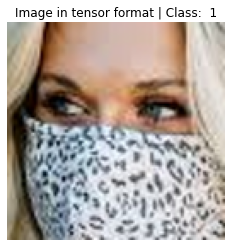

In [6]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

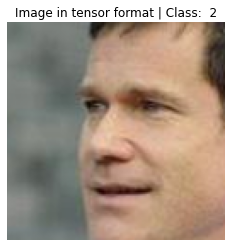

In [7]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

In [8]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layer1 = list(net.layer1.modules())
    layer2 = list(net.layer1.modules())
    layer3 = list(net.layer1.modules())
    layer4 = list(net.layer1.modules())
    
    layer_id = 1
    for layers in [layer1, layer2, layer3, layer4]:
        for layer in layers:
            if isinstance(layer, torch.nn.Linear) :

                writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
                                epoch )
                writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
                writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
                                    epoch )
                layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}Net-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

In [9]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

In [10]:
from torch import nn

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(
      nn.Conv2d(3, 16, 3),
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 16, 2, 2),
      nn.Conv2d(16, 16, 3),
      nn.ReLU(inplace=True),
      nn.Conv2d(16, 16, 2, 2),
      nn.Conv2d(16, 16, 3),
      nn.ReLU(inplace=True),
      nn.Linear(28, 3),
    )
    
  def forward(self, x):
    return self.classifier(x)

In [11]:
model = torchvision.models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(512, 3)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
from torchsummary import summary

summary(model, (3, 128, 128), batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 64, 64]           9,408
       BatchNorm2d-2           [64, 64, 64, 64]             128
              ReLU-3           [64, 64, 64, 64]               0
         MaxPool2d-4           [64, 64, 32, 32]               0
            Conv2d-5           [64, 64, 32, 32]          36,864
       BatchNorm2d-6           [64, 64, 32, 32]             128
              ReLU-7           [64, 64, 32, 32]               0
            Conv2d-8           [64, 64, 32, 32]          36,864
       BatchNorm2d-9           [64, 64, 32, 32]             128
             ReLU-10           [64, 64, 32, 32]               0
       BasicBlock-11           [64, 64, 32, 32]               0
           Conv2d-12           [64, 64, 32, 32]          36,864
      BatchNorm2d-13           [64, 64, 32, 32]             128
             ReLU-14           [64, 64,

In [13]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
    print("Running on CUDA.")
else:
    my_device = torch.device("cpu")
    print("No Cuda Available")

torch.cuda.empty_cache()

model = model.to(my_device)

epochs = 30
lr = 1e-3
dataset = 'mask'
prefix = 'Net-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

torch.cuda.empty_cache()

net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Running on CUDA.


Training epochs...:   3%|▎         | 1/30 [09:04<4:23:08, 544.43s/it]

Saving Best Model with Accuracy:  88.12615955473099
Epoch:   1 | Accuracy : 88.1262%


Training epochs...:   7%|▋         | 2/30 [12:58<2:48:48, 361.75s/it]

Saving Best Model with Accuracy:  92.72727272727273
Epoch:   2 | Accuracy : 92.7273%


Training epochs...:  10%|█         | 3/30 [14:07<1:42:35, 227.99s/it]

Saving Best Model with Accuracy:  94.58256029684601
Epoch:   3 | Accuracy : 94.5826%


Training epochs...:  13%|█▎        | 4/30 [15:15<1:11:31, 165.06s/it]

Saving Best Model with Accuracy:  95.58441558441558
Epoch:   4 | Accuracy : 95.5844%


Training epochs...:  17%|█▋        | 5/30 [16:24<54:18, 130.32s/it]  

Saving Best Model with Accuracy:  96.5491651205937
Epoch:   5 | Accuracy : 96.5492%


Training epochs...:  20%|██        | 6/30 [17:32<43:42, 109.26s/it]

Saving Best Model with Accuracy:  97.06864564007421
Epoch:   6 | Accuracy : 97.0686%


Training epochs...:  23%|██▎       | 7/30 [18:41<36:48, 96.02s/it] 

Saving Best Model with Accuracy:  97.47680890538034
Epoch:   7 | Accuracy : 97.4768%


Training epochs...:  27%|██▋       | 8/30 [19:49<31:56, 87.13s/it]

Saving Best Model with Accuracy:  97.95918367346938
Epoch:   8 | Accuracy : 97.9592%


Training epochs...:  30%|███       | 9/30 [20:57<28:26, 81.25s/it]

Epoch:   9 | Accuracy : 97.8850%


Training epochs...:  33%|███▎      | 10/30 [22:06<25:44, 77.21s/it]

Epoch:  10 | Accuracy : 97.8850%


Training epochs...:  37%|███▋      | 11/30 [23:14<23:35, 74.51s/it]

Saving Best Model with Accuracy:  98.5899814471243
Epoch:  11 | Accuracy : 98.5900%


Training epochs...:  40%|████      | 12/30 [24:22<21:46, 72.60s/it]

Epoch:  12 | Accuracy : 98.3673%


Training epochs...:  43%|████▎     | 13/30 [25:31<20:16, 71.58s/it]

Saving Best Model with Accuracy:  98.7012987012987
Epoch:  13 | Accuracy : 98.7013%


Training epochs...:  47%|████▋     | 14/30 [26:40<18:48, 70.51s/it]

Epoch:  14 | Accuracy : 98.5158%


Training epochs...:  50%|█████     | 15/30 [27:48<17:28, 69.88s/it]

Epoch:  15 | Accuracy : 98.5529%


Training epochs...:  53%|█████▎    | 16/30 [28:57<16:13, 69.53s/it]

Saving Best Model with Accuracy:  98.84972170686457
Epoch:  16 | Accuracy : 98.8497%


Training epochs...:  57%|█████▋    | 17/30 [30:05<14:59, 69.21s/it]

Epoch:  17 | Accuracy : 98.7755%


Training epochs...:  60%|██████    | 18/30 [31:14<13:47, 68.96s/it]

Epoch:  18 | Accuracy : 98.7755%


Training epochs...:  63%|██████▎   | 19/30 [32:23<12:38, 68.97s/it]

Saving Best Model with Accuracy:  98.96103896103897
Epoch:  19 | Accuracy : 98.9610%


Training epochs...:  67%|██████▋   | 20/30 [33:31<11:29, 68.90s/it]

Epoch:  20 | Accuracy : 98.8497%


Training epochs...:  70%|███████   | 21/30 [34:41<10:21, 69.10s/it]

Epoch:  21 | Accuracy : 98.9610%


Training epochs...:  73%|███████▎  | 22/30 [35:50<09:13, 69.24s/it]

Epoch:  22 | Accuracy : 98.8868%


Training epochs...:  77%|███████▋  | 23/30 [37:00<08:05, 69.38s/it]

Saving Best Model with Accuracy:  99.0352504638219
Epoch:  23 | Accuracy : 99.0353%


Training epochs...:  80%|████████  | 24/30 [38:10<06:57, 69.60s/it]

Epoch:  24 | Accuracy : 98.8868%


Training epochs...:  83%|████████▎ | 25/30 [39:20<05:47, 69.54s/it]

Epoch:  25 | Accuracy : 98.9610%


Training epochs...:  87%|████████▋ | 26/30 [42:44<07:19, 109.88s/it]

Saving Best Model with Accuracy:  99.10946196660483
Epoch:  26 | Accuracy : 99.1095%


Training epochs...:  90%|█████████ | 27/30 [43:56<04:55, 98.54s/it] 

Saving Best Model with Accuracy:  99.18367346938776
Epoch:  27 | Accuracy : 99.1837%
Epoch:  28 | Accuracy : 98.9610%


Training epochs...:  93%|█████████▎| 28/30 [49:58<05:55, 177.79s/it]

: 